In [1]:
Sys.setlocale(category = "LC_ALL", locale = "en_US.UTF-8")

[1] "en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/C"

# Dependencies

In [2]:
pacman::p_load(dplyr, ggplot2, ggbeeswarm, ggpubr, ggsignif, cowplot, ggh4x, ggrepel, ComplexHeatmap, lsmeans)

# Functions

In [3]:
source("/Users/anabbi/git/ped_CapTCRseq/R/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/color_schemes.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/Misc_functions.R")

In [4]:
scaleFUN <- function(x) sprintf("%.1f", x)

# Paths

In [5]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [6]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/"

# Main

In [7]:
meta_div <- readr::read_rds(paste0(datapath, "capTCRseq/meta_div_goodsamples.rds"))

In [8]:
meta_div <- meta_div[ meta_div$cancergroup != "Normal", ]
meta_div <- meta_div[ meta_div$cancergroup != "LFS", ]

In [9]:
table(meta_div$sampletype, useNA = "always")


cfDNA  PBMC Tumor  <NA> 
  274   534    18     0 

Separate PBMC and cfDNA

In [10]:
table(meta_div$cancergroup)


           Leukemia            Lymphoma        Solid tumors T-cell malignancies 
                370                 138                 274                  44 

In [11]:
meta_div <- meta_div[ meta_div$cancergroup != "T-cell malignancies", ]

In [12]:
pbmc <- meta_div[ which(meta_div$sampletype == "PBMC"),]
cfdna <- meta_div[ which(meta_div$sampletype == "cfDNA"),]

## Change relative to with baseline

In [13]:
pbmc <- meta_div[ which(meta_div$sampletype == "PBMC"),]
pbmc <- pbmc[ !is.na(pbmc$TRB),]

In [14]:
pbmc$log10shann_scaled <- scale(pbmc$log10shann)

In [15]:
diff_log10shann <- calculate_delta.fx(pbmc, "cycle", "log10shann_scaled")
diff_log10shann <- diff_log10shann[!is.na(diff_log10shann$Difference), ]

In [16]:
head(diff_log10shann)

sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,observed_Simpson,estimated_Simpson,SE_Simpson,basename,file,sampletype,Group,log10shann,log10shann_scaled,Difference
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,"<dbl[,1]>","<dbl[,1]>"
CHP_347_01,CHP_347,X01,0.8,126.72,13,ALL,0.8,1701,1,...,79.873,80.961,1.755,CHP_347-01-PBMC-DNA,batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_347-01-PBMC-DNA.txt,PBMC,CHP,2.029022,0.1834883,0.0000000
CHP_347_02,CHP_347,X02,6.4,1038.59,13,ALL,6.4,927,15,...,231.692,240.987,3.678,CHP_347-02-PBMC-DNA,batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_347-02-PBMC-DNA.txt,PBMC,CHP,2.447600,0.8883504,0.7048621
CHP_347_03,CHP_347,X03,37.6,768.80,13,ALL,37.6,2379,27,...,49.106,50.983,2.435,CHP_347-03-PBMC-DNA,batch7_25Oct2019/mixcr/clones/CLONES_TRBCHP_347-03-PBMC-DNA.txt,PBMC,CHP,1.841165,-0.1328528,-0.3163411
CHP_347_04,CHP_347,X04,0.8,1542.25,13,ALL,0.8,745,14,...,58.083,62.492,2.479,CHP_347-04-PBMC-DNA,batch6a_5Nov2019/mixcr/clones/CLONES_TRBCHP_347-04-PBMC-DNA.txt,PBMC,CHP,1.847980,-0.1213780,-0.3048664
CHP_347_05,CHP_347,X05,2.6,1278.87,13,ALL,2.6,2175,7,...,78.937,84.835,4.097,CHP_347-05-PBMC-DNA,batch8_14Jan2020/mixcr/clones/CLONES_TRBCHP_347-05-PBMC-DNA.txt,PBMC,CHP,2.006778,0.1460304,-0.0374579
CHP_348_01,CHP_348,X01,11.5,50.96,18,OS,11.5,1125,28,...,57.108,60.689,2.516,CHP_348-01-PBMC-DNA,batch2_Aug62019/mixcr/clones/CLONES_TRBCHP_348-01-PBMC-DNA.txt,PBMC,CHP,1.844738,-0.1268367,0.0000000


In [17]:
cfdna$log10shann_scaled <- scale(cfdna$log10shann)

In [18]:
diff_log10shann_cfdna <- calculate_delta.fx(cfdna, "cycle", "log10shann_scaled")
diff_log10shann_cfdna <- diff_log10shann_cfdna[ !is.na(diff_log10shann_cfdna$Difference),]

In [19]:
pbmc1 <- meta_div[ meta_div$sampletype == "PBMC" & !is.na(meta_div$CD3),]
pbmc1 <- pbmc1[ pbmc1$CD3 > 0,]

In [20]:
mycells <- c("`Naïve%`", "`SCM%`", "`CM%`", "`EM%`", "`TE%`", "`PD1%`", "`LAG3%`", "`TIM3%`")

In [21]:
for (i in 1:length(mycells)) {
    pbmc1$grp <- gsub("`", "", mycells[i])
    mycol <- paste0("Diff_", gsub("%", "", pbmc1$grp[1]))
    myvar <- paste0("scaled_", gsub("%", "", pbmc1$grp[1]))
    pbmc1[[myvar]] <- NA
    pbmc1[[myvar]] <- scale(pbmc1[[pbmc1$grp[1]]])
    mydiff <- calculate_delta.fx(pbmc1, "cycle", myvar)
    # print(summary(mydiff$Difference))
    pbmc1[[mycol]] <- mydiff$Difference[match(pbmc1$sample_id, mydiff$sample_id)]
}

In [22]:
summary(pbmc1$`TIM3%`)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.1595  5.3937 12.0974 17.7238 26.8116 81.5562      12 

In [23]:
pbmc1[ pbmc1$Patient == "CHP_343", c("TIM3%", "scaled_TIM3", "Diff_TIM3")]

,TIM3%,scaled_TIM3,Diff_TIM3
,<dbl>,"<dbl[,1]>",<dbl>
419,12.158590,-0.3396592,0.2605652
420,36.060606,1.1191399,1.7193643
421,45.022971,1.6661352,2.2663596
422,20.402299,0.1634747,0.7636991
418,7.889302,-0.6002245,0.0000000


In [24]:
# pivot_longer
pbmc1_long <- pbmc1 %>%
    select(
        sample_id, Patient, cycle, cancergroup,Age,  Relapse, Diff_Naïve, Diff_SCM, Diff_CM, Diff_EM, Diff_TE,
        Diff_PD1, Diff_LAG3, Diff_TIM3
    ) %>%
    tidyr::pivot_longer(cols = starts_with("Diff_"), names_to = "marker", values_to = "Diff")


In [25]:
head(pbmc1_long)

sample_id,Patient,cycle,cancergroup,Age,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>
CHP_343_02,CHP_343,X02,Solid tumors,8,0,Diff_Naïve,-0.4361997
CHP_343_02,CHP_343,X02,Solid tumors,8,0,Diff_SCM,0.3956547
CHP_343_02,CHP_343,X02,Solid tumors,8,0,Diff_CM,0.8951589
CHP_343_02,CHP_343,X02,Solid tumors,8,0,Diff_EM,0.1928534
CHP_343_02,CHP_343,X02,Solid tumors,8,0,Diff_TE,-0.4029691
CHP_343_02,CHP_343,X02,Solid tumors,8,0,Diff_PD1,0.2637392


In [26]:
pbmc1_long <- pbmc1_long[ !is.na(pbmc1_long$Diff),]

In [216]:
colnames(pbmc1)

[1] "sample_id"          "Patient"            "cycle"             
 [4] "FOLD"               "ATC"                "Age"               
 [7] "Disease_type"       "TE_fold"            "CD3"               
[10] "EM"                 "CM"                 "Naïve"             
[13] "SCM"                "TE"                 "EM%"               
[16] "CM%"                "Naïve%"             "SCM%"              
[19] "TE%"                "Naïve/TE"           "N+CM+SCM/TE+EM"    
[22] "PD-1"               "PDL1"               "LAG3"              
[25] "TIM3"               "CTLA4"              "PD1%"              
[28] "PDL1%"              "LAG3%"              "TIM3%"             
[31] "CTLA4%"             "Any NCR"            "PD1 + LAG3 + TIM3" 
[34] "cancergroup"        "agegroup"           "foldgroup"         
[37] "Remission"          "Relapse"            "Transplant"        
[40] "CART"               "vital_status"       "LOF"               
[43] "TRB"                "Reads"              "CPKR"              
[46] "Average_reads"      "VMR"                "Max_reads"         
[49] "Singletons"         "Doubletons"         "qD"                
[52] "Sample_Coverage"    "observed_Richness"  "estimated_Richness"
[55] "SE_Richeness"       "observed_Shannon"   "estimated_Shannon" 
[58] "SE_Shannon"         "observed_Simpson"   "estimated_Simpson" 
[61] "SE_Simpson"         "basename"           "file"              
[64] "sampletype"         "Group"              "log10shann"        
[67] "grp"                "scaled_Naïve"       "Diff_Naïve"        
[70] "scaled_SCM"         "Diff_SCM"           "scaled_CM"         
[73] "Diff_CM"            "scaled_EM"          "Diff_EM"           
[76] "scaled_TE"          "Diff_TE"            "scaled_PD1"        
[79] "Diff_PD1"           "scaled_LAG3"        "Diff_LAG3"         
[82] "scaled_TIM3"        "Diff_TIM3"

In [232]:
summary(pbmc1$Diff_LAG3[ pbmc1$cancergroup == "Solid tumors" & pbmc1$cycle == "X04"])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
-0.2594  0.4236  0.9769  1.3760  2.0998  3.7511       4 

In [221]:
summary(diff_log10shann_cfdna$Difference[ diff_log10shann_cfdna$cancergroup == "Lymphoma" & 
diff_log10shann_cfdna$cycle == "X05"])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-3.3303 -1.9151 -1.1965 -1.3386 -0.4972  0.2460 

In [217]:
head(diff_log10shann_cfdna)

sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,estimated_Simpson,SE_Simpson,basename,file,sampletype,Group,log10shann,log10shann_scaled,Difference,grp
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,"<dbl[,1]>","<dbl[,1]>",<chr>
CHP_343_01,CHP_343,X01,1.0,219.30,8,EWS,1.0,2421,1,...,1.000,0.000,CHP_343-01-cfDNA,batch1_cfDNA_30Jan2020/mixcr/clones/CLONES_TRBCHP_343-01-cfDNA.txt,cfDNA,CHP,0.0000000,-1.4680923,0.0000000,cfTCR Diversity
CHP_343_02,CHP_343,X02,0.3,459.04,8,EWS,0.3,1135,16,...,2.479,0.030,CHP_343-02_cfDNA,remaining_batch_5_cfDNA_22April2021/mixcr/clones/CLONES_TRBCHP_343-02_cfDNA.txt,cfDNA,CHP,0.4590908,-0.4180238,1.0500685,cfTCR Diversity
CHP_343_04,CHP_343,X04,1.5,536.63,8,EWS,1.5,2612,146,...,1.000,0.000,CHP_343-04_cfDNA,remaining_batch_5_cfDNA_22April2021/mixcr/clones/CLONES_TRBCHP_343-04_cfDNA.txt,cfDNA,CHP,0.0000000,-1.4680923,0.0000000,cfTCR Diversity
CHP_343_05,CHP_343,X05,2.1,371.20,8,EWS,2.1,2436,152,...,2.143,0.510,CHP_343-05-cfDNA,remaining_batch_3_cfDNA_15April2021/mixcr/clones/CLONES_TRBCHP_343-05-cfDNA.txt,cfDNA,CHP,0.2764618,-0.8357471,0.6323451,cfTCR Diversity
CHP_344_01,CHP_344,X01,0.0,247.80,6,BL,0.0,0,NA,...,6.417,0.286,CHP_344-01_cfDNA,batch5_cfDNA_25Jun2020/mixcr/clones/CLONES_TRBCHP_344-01_cfDNA.txt,cfDNA,CHP,0.8186877,0.4044744,0.0000000,cfTCR Diversity
CHP_344_02,CHP_344,X02,0.0,829.08,6,BL,0.0,0,NA,...,1.376,0.027,CHP_344-02_cfDNA,batch3a9_cfDNA_10Jul2020/mixcr/clones/CLONES_TRBCHP_344-02_cfDNA.txt,cfDNA,CHP,0.2164298,-0.9730570,-1.3775314,cfTCR Diversity


In [28]:
pbmc1_long$marker <- gsub("Diff_", "", pbmc1_long$marker)
pbmc1_long$marker <- paste0(pbmc1_long$marker, "%")

In [29]:
pbmc1_long_cells <- pbmc1_long[ pbmc1_long$marker %in% c("Naïve%", "SCM%", "CM%", "EM%", "TE%"), ]
pbmc1_long_ic <- pbmc1_long[ pbmc1_long$marker %in% c("PD1%", "LAG3%", "TIM3%"), ]

### Export by cancergroup

#### Leu

Stats

In [155]:
marker <- "TCR"
cancergrp <- "Leukemia"

grp_df <- diff_log10shann[diff_log10shann$cancergroup == cancergrp, ]
myformula <- as.formula(paste0("Difference", " ~ cycle + Age + (1 | Patient)"))
myfit <- lme4::lmer(myformula, data = grp_df) # keep cycle as categorical
lsm <- lsmeans(myfit, "cycle")
mylsm_grp <- summary(lsm)
mylsm_grp$cancergroup <- cancergrp # has to be same as original df
mylsm_grp$marker <- marker

myctrt_grp <- as.data.frame(lsmeans::contrast(lsm, "trt.vs.ctrl", ref = "X01"))
myctrt_grp$cancergroup <- cancergrp
myctrt_grp$marker <- marker

leu_tcr <- list(mylsm_grp, myctrt_grp)


In [156]:
marker <- "cfTCR"
cancergrp <- "Leukemia"

grp_df <- diff_log10shann_cfdna[diff_log10shann_cfdna$cancergroup == cancergrp, ]
myformula <- as.formula(paste0("Difference", " ~ cycle + Age + (1 | Patient)"))
myfit <- lme4::lmer(myformula, data = grp_df) # keep cycle as categorical
lsm <- lsmeans(myfit, "cycle")
mylsm_grp <- summary(lsm)
mylsm_grp$cancergroup <- cancergrp # has to be same as original df
mylsm_grp$marker <- marker

myctrt_grp <- as.data.frame(lsmeans::contrast(lsm, "trt.vs.ctrl", ref = "X01"))
myctrt_grp$cancergroup <- cancergrp
myctrt_grp$marker <- marker

leu_cftcr <- list(mylsm_grp, myctrt_grp)

In [157]:
leu_flow <- lsmeans_df.fx(pbmc1_long_cells, c("`Naïve%`", "`SCM%`", "`CM%`", "`EM%`", "`TE%`") ,"Leukemia")
leu_ncr <- lsmeans_df.fx(pbmc1_long_ic, c("`LAG3%`", "`TIM3%`", "`PD1%`") ,"Leukemia")

[1] "`SCM%`"
[1] "`CM%`"
[1] "`EM%`"
[1] "`TE%`"
[1] "`TIM3%`"
[1] "`PD1%`"


In [158]:
mysig_flow <- leu_flow[[2]]
mysig_flow <- mysig_flow[ mysig_flow$p.value < 0.05,]
mysig_flow$p.val <- sapply(mysig_flow$p.value, function(x) round_and_format(x) )

In [159]:
mysig_ncr <- leu_ncr[[2]]
mysig_ncr <- mysig_ncr[ mysig_ncr$p.value < 0.07,]
mysig_ncr$p.val <- sapply(mysig_ncr$p.value, function(x) round_and_format(x) )

In [160]:
mysig_ncr

,contrast,estimate,SE,df,t.ratio,p.value,cancergroup,marker,Cycle,p.val
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<chr>,<chr>
7,X04 - X01,0.8874753,0.3632379,47.15398,2.443234,0.06282666,Leukemia,TIM3%,4,0.06
11,X04 - X01,0.8980759,0.3645513,47.98800,2.463510,0.05974610,Leukemia,PD1%,4,0.06


In [161]:
mysig_flow <- leu_flow[[2]]
mysig_flow <- mysig_flow[ mysig_flow$p.value < 0.05,]
mysig_flow$p.val <- sapply(mysig_flow$p.value, function(x) round_and_format(x) )

Plot

In [162]:
diff_log10shann$grp <- "TCR Diversity"
diff_log10shann_cfdna$grp <- "cfTCR Diversity"

In [163]:
p_shann_leu <- delta_basespiderplot.fx(
    diff_log10shann[diff_log10shann$cancergroup == "Leukemia", ],
    "cycle", "factor(Relapse)", c("0" = "blue", "1" = "red")) 


In [164]:
p_shann_leu <- p_shann_leu + theme(legend.position = "none") +
  facet_wrap(~grp , nrow = 1, scales = "free_x", strip.position = "top") +
  theme(
    plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
    axis.title.x = element_blank(),
    legend.position = "none",
    strip.text.x = element_text(size = 13),
    strip.background.x = element_blank(),
    strip.placement = "outside"
  ) +
  ylab("D TCR diversity") +
  scale_x_discrete(get_breaks("cycle"),
    labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
  ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  scale_color_manual(labels = c("No Relapse", "Relapse"), values = c("0" = "blue", "1" = "red")) 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


In [165]:
pdf(paste0(plotpath, "Spiderplot_relapse_lgd.pdf"), width = 5, height = 5)
grid.draw(get_legend(p_shann_leu + theme(legend.position = "bottom"))) 
dev.off()

pdf 
  2

In [166]:
p_cfshann_leu <- delta_basespiderplot.fx(
    diff_log10shann_cfdna[diff_log10shann_cfdna$cancergroup == "Leukemia", ],
    "cycle", "factor(Relapse)", c("0" = "blue", "1" = "red"))

In [167]:
p_cfshann_leu <- p_cfshann_leu + theme(legend.position = "none") +
    facet_wrap(~grp, nrow = 1, scales = "free_x", strip.position = "top") +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D cfTCR diversity") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [168]:
pbmc1_long_cells$marker <- factor(pbmc1_long_cells$marker, levels = c("Naïve%", "SCM%", "CM%", "EM%", "TE%"))

In [169]:
p_leu <- ggplot(pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Leukemia", ], aes(x = cycle, y = Diff)) +
    geom_point(aes(color = factor(Relapse)), cex = 2) +
    geom_line(aes(group = Patient, color = factor(Relapse))) +
     scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    myplot +
    myaxis +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    geom_signif(
            data = mysig_flow,
            aes(xmin = 1, xmax = 4, annotations = p.val, y_position = 7),
            textsize = 3, vjust = -0.2, color = "black",
            manual = TRUE
        ) +
    facet_wrap(~marker, nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D T-cell subsets") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

Warning message in geom_signif(data = mysig_flow, aes(xmin = 1, xmax = 4, annotations = p.val, :
“Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position”


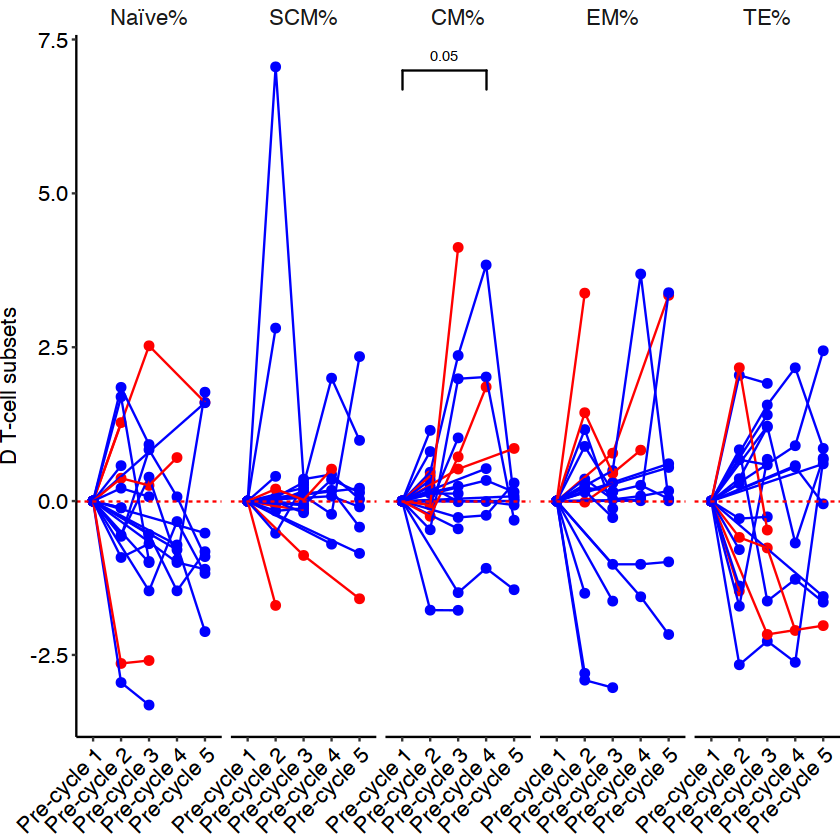

In [170]:
p_leu

In [171]:
p_leu_ic <- ggplot(pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Leukemia", ], aes(x = cycle, y = Diff)) +
    geom_point(aes(color = factor(Relapse)), cex = 2) +
    geom_line(aes(group = Patient, color = factor(Relapse))) +
    scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    myplot +
    myaxis +
    theme(
        plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
        geom_signif(
            data = mysig_ncr,
            aes(xmin = 1, xmax = 4, annotations = p.val, y_position = 7),
            textsize = 3, vjust = -0.2, color = "black",
            manual = TRUE
        ) +
    facet_wrap(~marker, nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D Immune Checkpoint proteins") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

Warning message in geom_signif(data = mysig_ncr, aes(xmin = 1, xmax = 4, annotations = p.val, :
“Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position”


In [172]:
mysig_ncr

,contrast,estimate,SE,df,t.ratio,p.value,cancergroup,marker,Cycle,p.val
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<chr>,<chr>
7,X04 - X01,0.8874753,0.3632379,47.15398,2.443234,0.06282666,Leukemia,TIM3%,4,0.06
11,X04 - X01,0.8980759,0.3645513,47.98800,2.463510,0.05974610,Leukemia,PD1%,4,0.06


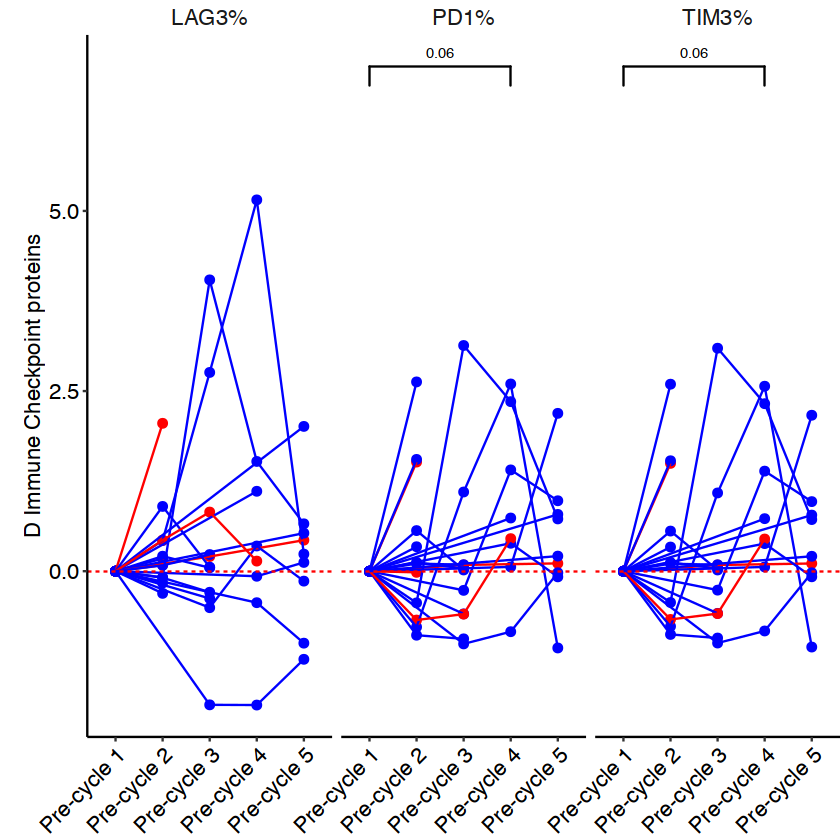

In [173]:
p_leu_ic

In [174]:
pdf(paste0(plotpath, "p_leu_spiderplots_overtime.pdf"), width = 20, height = 5)
cowplot::plot_grid(p_leu ,
p_leu_ic , 
p_shann_leu , 
p_cfshann_leu , labels = c("A", "B", "C"),
    rel_widths = c(0.5, 0.3, 0.13, 0.12), nrow = 1, ncol = 4
)
dev.off()

pdf 
  2

#### Lym

Stats

In [175]:
marker <- "TCR"
cancergrp <- "Lymphoma"

grp_df <- diff_log10shann[diff_log10shann$cancergroup == cancergrp, ]
myformula <- as.formula(paste0("Difference", " ~ cycle + Age + (1 | Patient)"))
myfit <- lme4::lmer(myformula, data = grp_df) # keep cycle as categorical
lsm <- lsmeans(myfit, "cycle")
mylsm_grp <- summary(lsm)
mylsm_grp$cancergroup <- cancergrp # has to be same as original df
mylsm_grp$marker <- marker

myctrt_grp <- as.data.frame(lsmeans::contrast(lsm, "trt.vs.ctrl", ref = "X01"))
myctrt_grp$cancergroup <- cancergrp
myctrt_grp$marker <- marker

lym_tcr <- list(mylsm_grp, myctrt_grp)


boundary (singular) fit: see help('isSingular')



In [176]:
marker <- "cfTCR"
cancergrp <- "Lymphoma"

grp_df <- diff_log10shann_cfdna[diff_log10shann_cfdna$cancergroup == cancergrp, ]
myformula <- as.formula(paste0("Difference", " ~ cycle + Age + (1 | Patient)"))
myfit <- lme4::lmer(myformula, data = grp_df) # keep cycle as categorical
lsm <- lsmeans(myfit, "cycle")
mylsm_grp <- summary(lsm)
mylsm_grp$cancergroup <- cancergrp # has to be same as original df
mylsm_grp$marker <- marker

myctrt_grp <- as.data.frame(lsmeans::contrast(lsm, "trt.vs.ctrl", ref = "X01"))
myctrt_grp$cancergroup <- cancergrp
myctrt_grp$marker <- marker

lym_cftcr <- list(mylsm_grp, myctrt_grp)

In [177]:
lym_flow <- lsmeans_df.fx(pbmc1_long_cells, c("`Naïve%`", "`SCM%`", "`CM%`", "`EM%`", "`TE%`") ,"Lymphoma")
lym_ncr <- lsmeans_df.fx(pbmc1_long_ic, c("`LAG3%`", "`TIM3%`", "`PD1%`") ,"Lymphoma")

[1] "`SCM%`"
[1] "`CM%`"


boundary (singular) fit: see help('isSingular')



[1] "`EM%`"
[1] "`TE%`"
[1] "`TIM3%`"
[1] "`PD1%`"


In [178]:
mysig_cftcr <- lym_cftcr[[2]]
mysig_cftcr <- mysig_cftcr[ mysig_cftcr$p.value < 0.05,]
mysig_cftcr$p.val <- sapply(mysig_cftcr$p.value, function(x) round_and_format(x) )

In [179]:
mysig_cftcr

,contrast,estimate,SE,df,t.ratio,p.value,cancergroup,marker,p.val
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,X02 - X01,-1.103019,0.3826108,24.38310,-2.882874,0.028394972,Lymphoma,cfTCR,0.03
2,X03 - X01,-1.469423,0.3522542,24.01231,-4.171485,0.001280050,Lymphoma,cfTCR,0.001
3,X04 - X01,-1.292509,0.3839032,24.48213,-3.366756,0.009114447,Lymphoma,cfTCR,0.009
4,X05 - X01,-1.173140,0.4330956,24.89962,-2.708731,0.041501093,Lymphoma,cfTCR,0.04


In [180]:
mysig_flow <- lym_flow[[2]]
mysig_flow <- mysig_flow[ mysig_flow$p.value < 0.05,]
mysig_flow$p.val <- sapply(mysig_flow$p.value, function(x) round_and_format(x) )

Plots

In [181]:
p_shann_lym <- delta_basespiderplot.fx(
    diff_log10shann[diff_log10shann$cancergroup == "Lymphoma", ],
    "cycle", "factor(Relapse)", c("0" = "blue", "1" = "red")
) + theme(legend.position = "none")

In [182]:
p_shann_lym <- p_shann_lym + theme(legend.position = "none") +
  facet_wrap(~grp, nrow = 1, scales = "free_x", strip.position = "top") +
  theme(
    plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
    axis.title.x = element_blank(),
    legend.position = "none",
    strip.text.x = element_text(size = 13),
    strip.background.x = element_blank(),
    strip.placement = "outside"
  ) +
  ylab("D TCR diversity") +
  scale_x_discrete(get_breaks("cycle"),
    labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
  ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [183]:
p_cfshann_lym <- delta_basespiderplot.fx(
    diff_log10shann_cfdna[diff_log10shann_cfdna$cancergroup == "Lymphoma", ],
    "cycle", "factor(Relapse)", c("0" = "blue", "1" = "red")
)

In [184]:
p_cfshann_lym <- p_cfshann_lym + theme(legend.position = "none") +
        geom_signif(
            data = mysig_cftcr,
            aes(xmin = c(1,1,1,1), xmax = c(2,3,4,5), annotations = p.val, y_position = c(0.9,1.3,1.7 ,2.1)),
            textsize = 3, vjust = -0.2, color = "black",
            manual = TRUE
        ) +
    facet_wrap(~grp, nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D cfTCR diversity") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

Warning message in geom_signif(data = mysig_cftcr, aes(xmin = c(1, 1, 1, 1), xmax = c(2, :
“Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position”


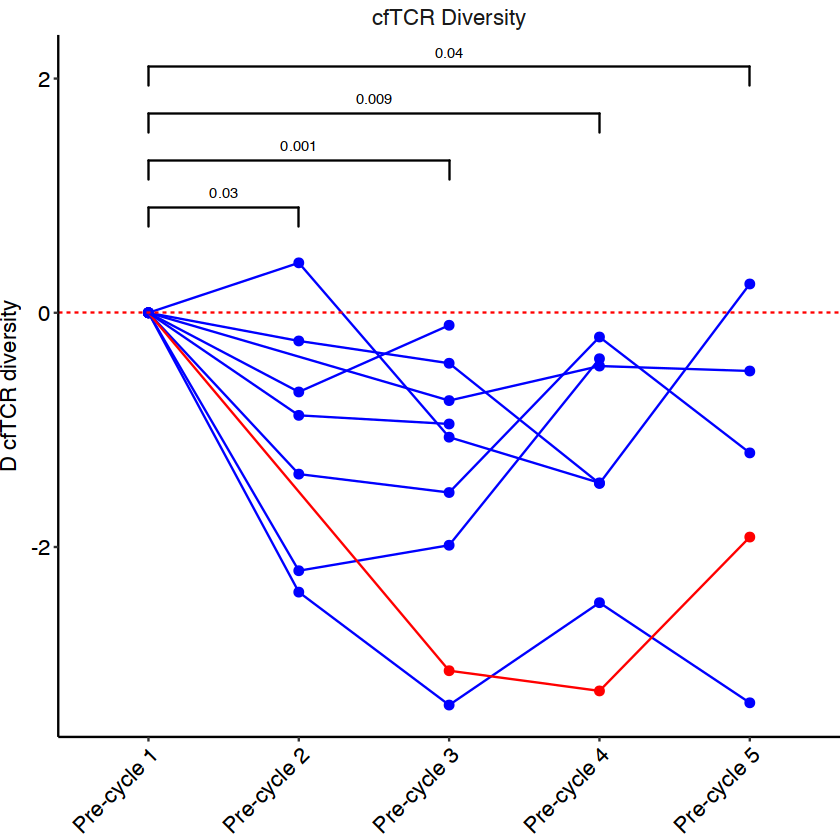

In [185]:
p_cfshann_lym

In [186]:
mysig_flow

,contrast,estimate,SE,df,t.ratio,p.value,cancergroup,marker,Cycle,p.val
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<chr>,<chr>
1,X02 - X01,-1.107809,0.3249371,8.286642,-3.409303,0.022938742,Lymphoma,Naïve%,2,0.02
2,X03 - X01,-1.376469,0.3249042,8.308460,-4.236537,0.006993296,Lymphoma,Naïve%,3,0.007


In [187]:
p_lym <- ggplot(pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Lymphoma", ], aes(x = cycle, y = Diff)) +
    geom_point(aes(color = factor(Relapse)), cex = 2) +
    geom_line(aes(group = Patient, color = factor(Relapse))) +
    scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    myplot +
    myaxis +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
            geom_signif(
            data = mysig_flow,
            aes(xmin = c(1,1), xmax = c(2,3), annotations = p.val, y_position = c(4.5,5)),
            textsize = 3, vjust = -0.2, color = "black",
            manual = TRUE
        ) +
    facet_wrap(~marker, nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D T-cell subsets") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

Warning message in geom_signif(data = mysig_flow, aes(xmin = c(1, 1), xmax = c(2, :
“Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position”


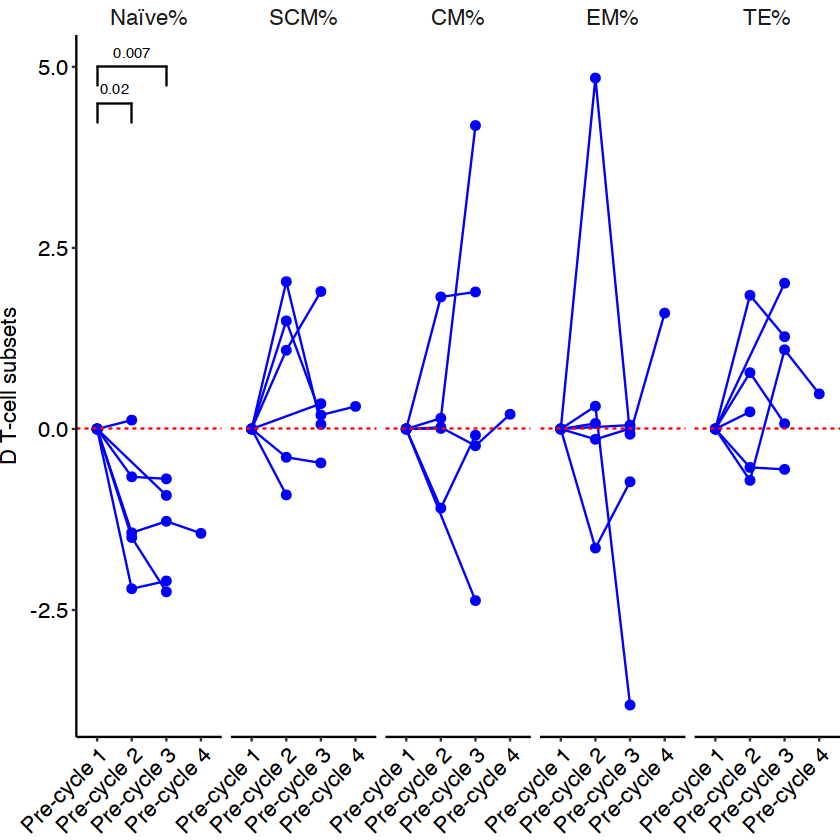

In [188]:
p_lym

In [189]:
p_lym_ic <- ggplot(pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Lymphoma", ], aes(x = cycle, y = Diff)) +
    geom_point(aes(color = factor(Relapse)), cex = 2) +
    geom_line(aes(group = Patient, color = factor(Relapse))) +
    scale_color_manual(values = c("0" = "blue", "1" = "red"))  +
    myplot +
    myaxis +
    theme(plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    facet_wrap(~marker, nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D Immune Checkpoint proteins") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [190]:
pdf(paste0(plotpath, "p_lym_spiderplots_overtime.pdf"), width = 20, height = 5)
cowplot::plot_grid(p_lym,
    p_lym_ic ,
    p_shann_lym ,
    p_cfshann_lym,  labels = c("D", "E", "F"),
    rel_widths = c(0.5, 0.3, 0.13, 0.12), nrow = 1, ncol = 4
)
dev.off()

pdf 
  2

#### Solid

Stats

In [191]:
marker <- "TCR"
cancergrp <- "Solid tumors"

grp_df <- diff_log10shann[diff_log10shann$cancergroup == cancergrp, ]
myformula <- as.formula(paste0("Difference", " ~ cycle + Age + (1 | Patient)"))
myfit <- lme4::lmer(myformula, data = grp_df) # keep cycle as categorical
lsm <- lsmeans(myfit, "cycle")
mylsm_grp <- summary(lsm)
mylsm_grp$cancergroup <- cancergrp # has to be same as original df
mylsm_grp$marker <- marker

myctrt_grp <- as.data.frame(lsmeans::contrast(lsm, "trt.vs.ctrl", ref = "X01"))
myctrt_grp$cancergroup <- cancergrp
myctrt_grp$marker <- marker

solid_tcr <- list(mylsm_grp, myctrt_grp)


In [192]:
marker <- "cfTCR"
cancergrp <- "Solid tumors"

grp_df <- diff_log10shann_cfdna[diff_log10shann_cfdna$cancergroup == cancergrp, ]
myformula <- as.formula(paste0("Difference", " ~ cycle + Age + (1 | Patient)"))
myfit <- lme4::lmer(myformula, data = grp_df) # keep cycle as categorical
lsm <- lsmeans(myfit, "cycle")
mylsm_grp <- summary(lsm)
mylsm_grp$cancergroup <- cancergrp # has to be same as original df
mylsm_grp$marker <- marker

myctrt_grp <- as.data.frame(lsmeans::contrast(lsm, "trt.vs.ctrl", ref = "X01"))
myctrt_grp$cancergroup <- cancergrp
myctrt_grp$marker <- marker

solid_cftcr <- list(mylsm_grp, myctrt_grp)

In [193]:
solid_flow <- lsmeans_df.fx(pbmc1_long_cells, c("`Naïve%`", "`SCM%`", "`CM%`", "`EM%`", "`TE%`") ,"Solid tumors")
solid_ncr <- lsmeans_df.fx(pbmc1_long_ic, c("`LAG3%`", "`TIM3%`", "`PD1%`") ,"Solid tumors")

[1] "`SCM%`"
[1] "`CM%`"
[1] "`EM%`"
[1] "`TE%`"
[1] "`TIM3%`"


boundary (singular) fit: see help('isSingular')



[1] "`PD1%`"


boundary (singular) fit: see help('isSingular')



In [194]:
mysig_flow <- solid_flow[[2]]
mysig_flow <- mysig_flow[ mysig_flow$p.value < 0.05,]
mysig_flow$p.val <- sapply(mysig_flow$p.value, function(x) round_and_format(x) )

In [195]:
mysig_ncr <- solid_ncr[[2]]
mysig_ncr <- mysig_ncr[ mysig_ncr$p.value < 0.07,]
mysig_ncr$p.val <- sapply(mysig_ncr$p.value, function(x) round_and_format(x) )

In [196]:
mysig_ncr

,contrast,estimate,SE,df,t.ratio,p.value,cancergroup,marker,Cycle,p.val
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<chr>,<chr>
3,X04 - X01,1.3383570,0.3250047,42.54020,4.117962,0.0006627499,Solid tumors,LAG3%,4,6.6e-04
6,X03 - X01,1.0934944,0.3362259,43.07846,3.252261,0.0082395722,Solid tumors,TIM3%,3,0.008
7,X04 - X01,1.0997256,0.3111225,43.13131,3.534703,0.0037161158,Solid tumors,TIM3%,4,0.004
8,X05 - X01,0.9670443,0.3331752,45.00806,2.902510,0.0205948234,Solid tumors,TIM3%,5,0.02
10,X03 - X01,1.1017314,0.3361525,43.83730,3.277475,0.0076117292,Solid tumors,PD1%,3,0.008
11,X04 - X01,1.1073183,0.3110988,43.91529,3.559378,0.0034157782,Solid tumors,PD1%,4,0.003
12,X05 - X01,0.9723119,0.3330934,45.82752,2.919037,0.0196016863,Solid tumors,PD1%,5,0.02


Plots

In [197]:
p_shann_solid <- delta_basespiderplot.fx(
    diff_log10shann[diff_log10shann$cancergroup == "Solid tumors", ],
    "cycle", "factor(Relapse)", c("0" = "blue", "1" = "red")
) + theme(legend.position = "none")

In [198]:
p_shann_solid <- p_shann_solid + theme(legend.position = "none") +
  facet_wrap(~grp, nrow = 1, scales = "free_x", strip.position = "top") +
  theme(plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
    axis.title.x = element_blank(),
    legend.position = "none",
    strip.text.x = element_text(size = 13),
    strip.background.x = element_blank(),
    strip.placement = "outside"
  ) +
  ylab("D TCR diversity") +
  scale_x_discrete(get_breaks("cycle"),
    labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
  ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [199]:
p_cfshann_solid <- delta_basespiderplot.fx(
    diff_log10shann_cfdna[diff_log10shann_cfdna$cancergroup == "Solid tumors", ],
    "cycle", "factor(Relapse)", c("0" = "blue", "1" = "red")
)

In [200]:
p_cfshann_solid <- p_cfshann_solid + theme(legend.position = "none") +
    facet_wrap(~grp, nrow = 1, scales = "free_x", strip.position = "top") +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D cfTCR diversity") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [201]:
p_solid <- ggplot(pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Solid tumors", ], aes(x = cycle, y = Diff)) +
    geom_point(aes(color = factor(Relapse)), cex = 2) +
    geom_line(aes(group = Patient, color = factor(Relapse))) +
    scale_color_manual( values = c("0" = "blue", "1" = "red"))  +
    myplot +
    myaxis +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
            geom_signif(
            data = mysig_flow,
            aes(xmin = c(1,1,1), xmax = c(2,3,4), annotations = p.val, y_position = c(4.6,5,5.4)),
            textsize = 3, vjust = -0.2, color = "black",
            manual = TRUE
        ) +
    facet_wrap(~marker, nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D T-cell subsets") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

Warning message in geom_signif(data = mysig_flow, aes(xmin = c(1, 1, 1), xmax = c(2, :
“Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position”


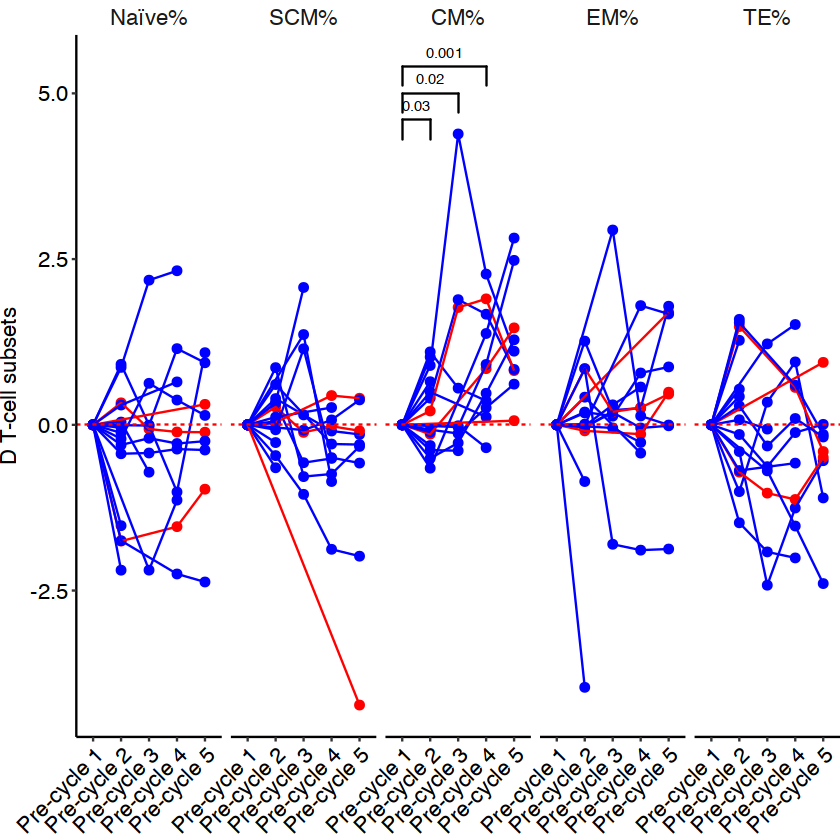

In [202]:
p_solid

In [203]:
p_solid_ic <- ggplot(pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Solid tumors", ], aes(x = cycle, y = Diff)) +
    geom_point(aes(color = factor(Relapse)), cex = 2) +
    geom_line(aes(group = Patient, color = factor(Relapse))) +
    scale_color_manual(values = c("0" = "blue", "1" = "red"))  +
    myplot +
    myaxis +
    theme(plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
                geom_signif(
            data = mysig_ncr,
            aes(xmin = c(1,1,1,1,1,1,1), xmax = c(4,3,4,5,3,4,5), annotations = p.val, y_position = c(4.2,3.6,4,4.4,3.6,4,4.4)),
            textsize = 3, vjust = -0.2, color = "black",
            manual = TRUE
        ) +
    facet_wrap(~marker, nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D Immune Checkpoint proteins") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

Warning message in geom_signif(data = mysig_ncr, aes(xmin = c(1, 1, 1, 1, 1, 1, :
“Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position”


In [204]:
pdf(paste0(plotpath, "p_solid_spiderplots_overtime.pdf"), width = 20, height = 5)
cowplot::plot_grid(p_solid,
    p_solid_ic,
    p_shann_solid ,
    p_cfshann_solid, labels = c("G", "H", "I"),
    rel_widths = c(0.5, 0.3, 0.13, 0.12), nrow = 1, ncol = 4
)
dev.off()


pdf 
  2